In [1]:
from light_curve import LightCurve
import joblib
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from torchvision import transforms
import aug
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from sklearn.metrics import accuracy_score

## Dataset


In [2]:
path_macho = '/Users/francisco/Documents/data/macho/full.pkl'
data_macho = joblib.load(path_macho)
path_asas = '/Users/francisco/Documents/data/asas/full.pkl'
data_asas = joblib.load(path_asas)
path_linear = '/Users/francisco/Documents/data/linear/full.pkl'
data_linear = joblib.load(path_linear)

## Cargar datos,period fold y normalizacion

In [3]:
all_data = data_macho + data_asas + data_linear

In [4]:
len(all_data)

76761

In [5]:
for lc in all_data:
    lc.period_fold()
A = [[lc.times,lc.measurements] for lc in all_data]
X = np.array(A)
X = X.transpose().tolist()


/var/folders/1z/7t_pnhds34b238n904xz5fw40000gn/T/ipykernel_6948/2314868560.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(A)


In [6]:
max_value = max([lc.max_value() for lc in all_data])
min_value = min([lc.min_value() for lc in all_data])

In [7]:
for lc in all_data:
    lc.normalize(min_value,max_value)
    lc.period_fold()
X = [[lc.times,lc.measurements,lc.errors] for lc in all_data]



In [8]:
from keras.utils.np_utils import to_categorical
classnames, y_inds = np.unique([str(lc.label) for lc in all_data],return_inverse=True)
Y = to_categorical(y_inds, len(classnames))



2023-05-06 22:58:42.106343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Exploracion

In [9]:
len(classnames)

40

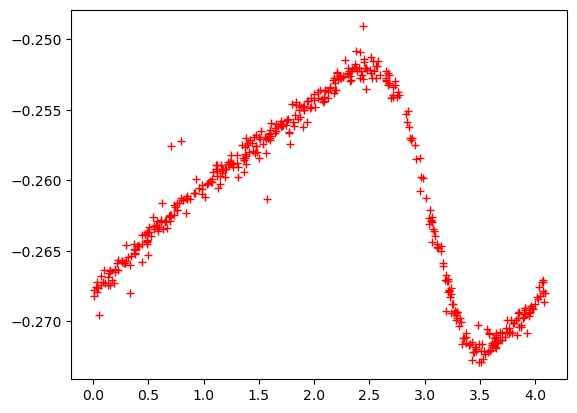

In [10]:
import matplotlib.pyplot as plt
plt.plot(X[200][0],X[200][1],'r+')

In [11]:
import aug
import torch

In [12]:
rm = random.choice(aug.augment_pool())

In [13]:
curva = torch.tensor([X[200][0],X[200][1]])

/var/folders/1z/7t_pnhds34b238n904xz5fw40000gn/T/ipykernel_6948/1944209949.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/torch/csrc/utils/tensor_new.cpp:204.)
  curva = torch.tensor([X[200][0],X[200][1]])


In [14]:
augmentation = random.choice(aug.augment_pool())
augmented = augmentation(curva)

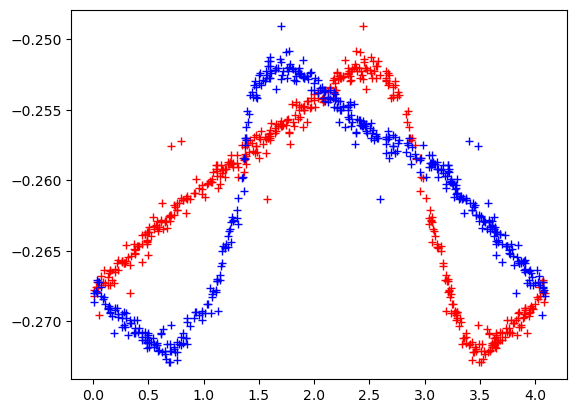

In [15]:
plt.plot(curva[0],curva[1],'r+')
plt.plot(augmented[0],augmented[1],'b+')

## Training Encoder

In [16]:
def dataset_split(data,ratio):
  unlabeled_size =1-(1/(ratio+1))
  
  x_train, x_val, y_train, y_val = train_test_split(np.array(data[1]),np.array(data[0]),test_size= 0.2,stratify=np.array(data[0]))

  
  x_train, x_unlabeled, y_train, y_unlabeled = train_test_split(x_train,y_train,test_size= unlabeled_size,stratify = y_train )


  return y_train,x_train,y_val,x_val,x_unlabeled,y_unlabeled

In [30]:
def train_epoch(model, dataloader, loss_function, optimizer):
  """Funcion para realizar el entrenamiento de una epoca
    Inputs
    -------
    model : torch.model
      modelo a entrenar
    dataloader: torch.dataloader
      datos con los cuales se entrena
    loss_function: torch.loss_fn
      funcion de perdida para el entrenamiento(entropia cruzada)
    optimizer: torch.optimizer
      funcion de optimizacion(adam)
    Returns
    -------
    list:
    entrega un tensor con los valores de ouputs entrenamiento, labels y losses
  """
  model.train()
  train_outputs = []
  train_labels = []
  train_losses = []

  for data in dataloader:
    targets = data[1].cuda()
    sample = data[0].float().cuda()
    seq_len = data[2]
    batch_size = targets.shape[0]

    outputs = model([sample[0],sample[1],seq_len])
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_losses.append(loss.item()*batch_size)
    train_outputs.append(outputs.detach())
    train_labels.append(targets.detach())

  return torch.tensor(train_losses), torch.cat(train_outputs), torch.cat(train_labels)

In [31]:
def val_epoch(model, dataloader, loss_function):
  """Funcion para realizar la validacion de una epoca
    Inputs
    -------
    model : torch.model
      modelo a entrenar
    dataloader: torch.dataloader
      datos con los cuales se entrena
    loss_function: torch.loss_fn
      funcion de perdida para el entrenamiento(entropia cruzada)
    Returns
    -------
    list:
    entrega un tensor con los valores de ouputs validacion, labels y losses
  """
  model.eval()
  val_outputs= []
  val_labels = []
  val_losses = []

  with torch.no_grad():
    for data in dataloader:
      targets = data[1].cuda()
      sample = data[0].float().cuda()
      seq_len = data[2]
      batch_size = targets.shape[0]

      outputs = model([sample[0],sample[1],seq_len])

      loss = loss_function(outputs, targets)

      val_losses.append(loss.item()*batch_size)
      val_outputs.append(outputs.detach())
      val_labels.append(targets.detach())

  return torch.tensor(val_losses), torch.cat(val_outputs), torch.cat(val_labels)

In [32]:
def get_scores(losses, outputs, labels):
  """Funcion obtener escores a partir de losses outputs y labels
  Inputs
  -------
  losses : list
    lista de losses
  outputs : list
    lista de outputs
  labels : list
    lista con los labels
  Returns
  -------
  acc: float
    valor de accuracy
  loss: float
    valor de loss
  
    """
  pred = torch.argmax(outputs, dim=1).cpu().numpy()
  true_label = labels.cpu().numpy()
  num = labels.shape[0]
  loss = torch.sum(losses).item()/num
  acc = accuracy_score(true_label, pred)
  return loss, acc

In [33]:
class data_LC(Dataset):
    
    def __init__(self,input,label):
        self.data = input
        self.seq_len = [len(xi) for xi in input]
        self.labels = label
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        return self.data[index],self.labels[index],self.seq_len[index]
    

In [35]:

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 40):
        super(ResNet, self).__init__()
        self.in_channels = in_channels
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3, kernel_size=3, stride=1, padding=1)
        self.layer2 = self._make_layer(128, 4, kernel_size=3, stride=2, padding=1)
        self.layer3 = self._make_layer(256, 6, kernel_size=3, stride=2, padding=1)
        self.layer4 = self._make_layer(512, 3, kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, kernel_size, stride, padding):
        layers = []
        layers.append(ResBlock(self.in_channels, out_channels, kernel_size, stride, padding))
        self.in_channels = out_channels
        for i in range(num_blocks - 1):
            layers.append(ResBlock(out_channels, out_channels, kernel_size, 1, padding))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [36]:
BATCH_SIZE = 64
LR = 1e-3
epochs = 20

In [37]:
device ='cpu'

In [38]:
encoder = ResNet()
encoder.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(encoder.parameters(), lr=LR)

In [39]:
x_tot, x_enc, y_tot, y_enc = train_test_split(X,Y,test_size=0.15)
x_train, x_val, y_train, y_val = train_test_split(x_enc,y_enc,test_size=0.7)
data_train = [y_train,x_train]
data_val = [y_val,x_val]

In [40]:
dataset_train = data_LC(x_train,y_train)
dataset_val = data_LC(x_val,y_val)
train_loader_base = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle =True, num_workers=2, pin_memory=True)
val_loader_base = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle =True, num_workers=2, pin_memory=True)


In [41]:
best_param_net3_path = 'best_param_encoder.bin'

In [42]:
best_val_loss = np.inf
loss_train = []
loss_val = []
not_improve_epochs = 0
tolerance = 5
epoch = 0
while not_improve_epochs<tolerance:
  epoch+=1
  print(f"Epoch {epoch}/{epochs}")
  train_loss, train_out, train_targets = train_epoch(encoder, train_loader_base, criterion, optimizer)
  loss, acc = get_scores(train_loss, train_out, train_targets)
  loss_train.append(loss)
  print("Train Loss: {:.3f}\tTrain Acc: {:.3f}".format(loss, acc))

  val_loss, val_out, val_targets = val_epoch(encoder, val_loader_base, criterion)
  loss, acc = get_scores(val_loss, val_out, val_targets)
  loss_val.append(loss)
  print("Validation Loss: {:.3f}\tValidation Acc: {:.3f}".format(loss, acc))

  if loss < best_val_loss :
    torch.save(encoder.state_dict(),best_param_net3_path)
    best_val_loss = loss
    not_improve_epochs=0
  else:
    not_improve_epochs+=1

Epoch 1/20


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/francisco/anaconda3/envs/ssl/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/francisco/anaconda3/envs/ssl/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'data_LC' on <module '__main__' (built-in)>


KeyboardInterrupt: 